In [2]:
import numpy as np
from scipy.optimize import root_scalar, root
import matplotlib.pyplot as plt
from astropy import units as u
import random
from astropy import coordinates as acoord

import galpy
from galpy.orbit import Orbit
from galpy import potential as pot
from galpy.util import coords, conversion #for unit conversions

# Orbit Uncertainties

In [45]:
def multorb(pos, vel, pos_sig, vel_sig, time_array, number, d1, d2, MW):
    """
    Samples a number [number argument] of orbits of 
    an object based on the current best values of its 
    initial conditions as well as uncertainties. New 
    orbits are made by sampling initial conditions 
    assuming a Gaussian distribution. 
    
    Inputed values should be:
    pos = [ra(deg), dec(deg), dist(kpc)]
    vel = [mu_ra(mas/yr), mu_dec(mas/yr), vlos(km/s)]
    and same for errors. This is to match the galpy 
    documentation, but any other list of pos and vel
    that matches the documentation should work as well. 
    https://docs.galpy.org/en/v1.7.2/reference/orbitinit.html
    """
    
    #0) Define initial conditions (IC) and error (sigma)
    IC = pos + vel
    sigma = pos_sig + vel_sig
    size = len(IC)
    
    #1) Get normally distributed values of ICs
    print("Getting randos...")
    ICs = np.zeros((number,size))
    for i in range(number):
        b = np.random.normal(loc = IC, scale = sigma, size=None)
        ICs[i] = b
    
    #3) Use these ICs to create unique orbits and plots
    orbs = []
    print("initializing orbits...")
    for ic in ICs:
        orb = Orbit(vxvv=ic, radec=True)
        orb.integrate(time_array, MW)
        orbs.append(orb)
        
    #4) Get the past conditions at -4 Gyr ago
    PCs = []
    
    for orb in orbs:
        pos_past = [orb.ra(time_array[-1]), orb.dec(time_array[-1]), orb.dist(time_array[-1])]
        vel_past = [orb.pmra(time_array[-1]), orb.pmdec(time_array[-1]), orb.vlos(time_array[-1])]
        
        #Converting to galactocentric using astropy
        c = acoord.SkyCoord(ra=pos_past[0]*u.degree, dec=pos_past[1]*u.degree,
                    distance=pos_past[2]*u.kpc,
                    pm_ra_cosdec=vel_past[0]*u.mas/u.yr,
                    pm_dec=vel_past[1]*u.mas/u.yr,
                    radial_velocity=vel_past[2]*u.km/u.s,
                    frame='icrs')
        gc = c.transform_to(acoord.Galactocentric)
        #print(gc)
        pc = [gc.x.value, gc.y.value, gc.z.value, gc.v_x.value, gc.v_y.value, gc.v_z.value]
        
        #Append galactic values
        PCs.append(pc)

    #5) Plot the main orbit
    print("Plotting main")
    orb_best = Orbit(vxvv=IC, radec=True)
    orb_best.integrate(time_array, MW)
    
    pos_past = [orb_best.ra(time_array[-1]), orb_best.dec(time_array[-1]), orb_best.dist(time_array[-1])]
    vel_past = [orb_best.pmra(time_array[-1]), orb_best.pmdec(time_array[-1]), orb_best.vlos(time_array[-1])]
    
    c = acoord.SkyCoord(ra=pos_past[0]*u.degree, dec=pos_past[1]*u.degree,
                    distance=pos_past[2]*u.kpc,
                    pm_ra_cosdec=vel_past[0]*u.mas/u.yr,
                    pm_dec=vel_past[1]*u.mas/u.yr,
                    radial_velocity=vel_past[2]*u.km/u.s,
                    frame='icrs')
    gc = c.transform_to(acoord.Galactocentric)
    pc = [gc.x.value, gc.y.value, gc.z.value, gc.v_x.value, gc.v_y.value, gc.v_z.value]
    print(f"Best Fit Past Condition:{pc}")
    
    orb_best.plot(d1=d1, d2=d2, color="k", linewidth=3, linestyle="dashed",
                 zorder=10, label=r'Best Fit Orbit')
    #plt.legend()
    
    
    #6) Plot the other orbits
    print("Plotting secondaries...")
    for i in range(len(orbs)):
        if i == 0:
            orbs[i].plot(d1=d1,d2=d2, linewidth=0.5, linestyle="dotted", color="grey", overplot=True, label="Sampled")
            plt.legend()
        orbs[i].plot(d1=d1,d2=d2, linewidth=0.5, linestyle="dotted", color="grey", overplot=True,label="_nolegend_")

    #7) Return the past conditions    
    return PCs

Getting randos...
initializing orbits...
Plotting main
Best Fit Past Condition:[17.1923170991112, 479.79520609483313, -211.76629388938204, 14.768175830075673, -108.78076978050476, 34.03491921031735]
Plotting secondaries...
Getting randos...
initializing orbits...
Plotting main
Best Fit Past Condition:[17.1923170991112, 479.79520609483313, -211.76629388938204, 14.768175830075673, -108.78076978050476, 34.03491921031735]
Plotting secondaries...


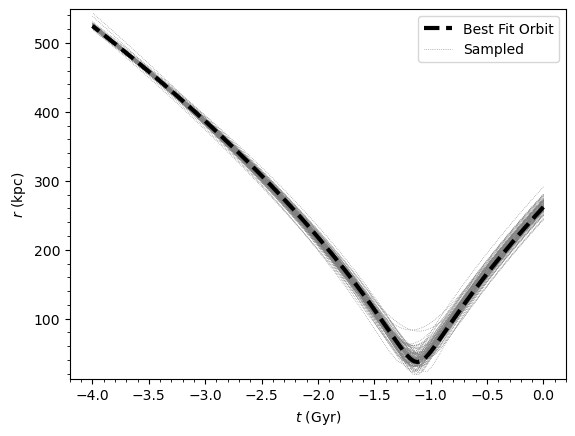

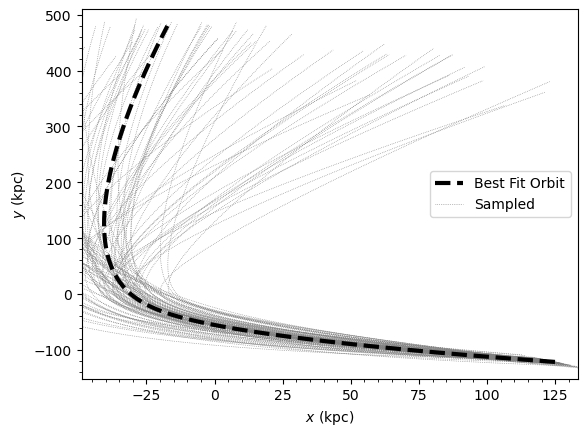

In [46]:
#RA & Dec from Munoz et al. 2018
#Velocities and distance from Pace et al. 2022 (from GAIA EDR3)
pos = [152.1146, 12.3059, 258.2]
vel = [-0.05, -0.12, 282.9]
pos_sig = [5e-4, 0.005, 9.5]
vel_sig = [0.014, 0.01, 0.5]
ts = np.linspace(0,-4,1001)*u.Gyr

mw   = pot.MWPotential2014
#mwdf = pot.MWPotential2014 + pot.ChandrasekharDynamicalFrictionForce(GMs = mean*u.Msun, rhm = 0.916*u.kpc)

PCs = multorb(pos,vel,pos_sig,vel_sig, ts, 100,'t','r', mw)
PCs = multorb(pos,vel,pos_sig,vel_sig, ts, 100,'x','y', mw)
#plt.title("Possible Orbits of Leo I")

#Get 10 random past conditions...
chosen = random.sample(PCs, 10)
#print(chosen)

In [47]:
mean = 1.8e9
std = 1.3e9
print(np.random.normal(loc=mean, scale = std, size=10))

[ 1.73802485e+09  2.01243670e+09  6.95250238e+08  7.77257083e+08
  8.60917325e+08 -1.12577795e+08 -1.45409384e+09  1.73671165e+09
  2.24777478e+09  5.57017989e+08]


In [48]:
mwdf = pot.MWPotential2014 + pot.ChandrasekharDynamicalFrictionForce(GMs = mean*u.Msun, rhm = 0.916*u.kpc)

Getting randos...
initializing orbits...
Plotting main
Best Fit Past Condition:[22.045280726131203, 490.3295496554042, -221.73436898887394, 13.263662155182299, -114.1195891145813, 37.951361804854706]
Plotting secondaries...


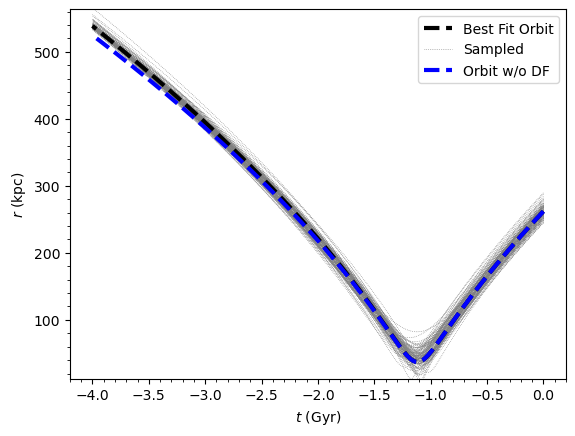

In [49]:
PCs = multorb(pos,vel,pos_sig,vel_sig, ts, 100,'t','r', mwdf)
#PCs = multorb(pos,vel,pos_sig,vel_sig, ts, 100,'x','y', mwdf)

orb_best = Orbit(vxvv=pos+vel, radec=True)
orb_best.integrate(ts, pot.MWPotential2014)
orb_best.plot(d1="t", d2="r", color="blue", linewidth=3, overplot=True, linestyle="dashed", zorder=10, label=r'Orbit w/o DF')
plt.legend()

#orb_best.plot(d1="x", d2="y", color="k", linewidth=3, linestyle="dashed",zorder=10, label=r'Best Fit Orbit')

Getting randos...
initializing orbits...
Plotting main
Best Fit Past Condition:[22.045280726131203, 490.3295496554042, -221.73436898887394, 13.263662155182299, -114.1195891145813, 37.951361804854706]
Plotting secondaries...


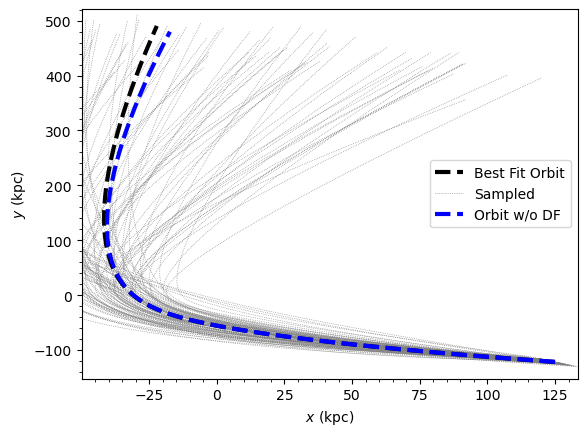

In [52]:
#PCs = multorb(pos,vel,pos_sig,vel_sig, ts, 100,'t','r', mwdf)
PCs = multorb(pos,vel,pos_sig,vel_sig, ts, 100,'x','y', mwdf)

#orb_best = Orbit(vxvv=pos+vel, radec=True)
#orb_best.integrate(ts, pot.MWPotential2014)
#orb_best.plot(d1="t", d2="r", color="blue", linewidth=3, overplot=True, linestyle="dashed", zorder=10, label=r'Orbit w/o DF')
#plt.legend()

orb_best.plot(d1="x", d2="y", color="blue", linewidth=3, linestyle="dashed",zorder=10, label=r'Orbit w/o DF', overplot=True)
plt.legend()